# An attempt to re-create the shape of our energy histograms

In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
# particle energy and stopping power

dEdat = np.loadtxt('../stopping_power_silicon.txt',skiprows=8,usecols=(0,1))

In [3]:
# particle energy and flux
fluxdat = np.loadtxt('../proton_L2_solarMax_11mm_Shielding.txt',comments='#')

In [4]:
fluxdat

array([[  1.00000000e-01,   1.73680000e-02],
       [  1.01389739e-01,   1.74180000e-02],
       [  1.02798792e-01,   1.74690000e-02],
       ..., 
       [  9.72774075e+04,   6.30890000e-05],
       [  9.86293098e+04,   6.07760000e-05],
       [  1.00000000e+05,   5.85570000e-05]])

In [5]:
print(np.min(dEdat[:,0]),np.max(dEdat[:,0]))

0.001 10000.0


In [6]:
print(np.min(fluxdat[:,0]),np.max(fluxdat[:,0]))

0.1 100000.0


In [7]:
# dEdat and fluxdat are mismatched - we can only go from .1 MeV to 10000 MeV

#dEdat = dEdat[np.where(dEdat[:,0]>=1e-1)[0],:]
fluxdat = fluxdat[np.where(fluxdat[:,0]<10000)[0],:]

In [8]:
# interpolate fluxes onto dE/dx or vice versa

def interpolate_on_array(val,arr):
    '''Arr is of shape (x,2). Returns the value of the second axis obtained via interpolating over the first'''
    closest = np.argmin(np.abs(arr[:,0]-val))
    if arr[closest,0] == val:
        return arr[closest,1]

    elif arr[closest,0] < val:
        upper = closest+1
        lower = closest
    elif arr[closest,0] > val:
        upper = closest
        lower = closest-1
        
    hi = arr[upper,0]
    lo = arr[lower,0]
    interp = (val-lo)/(hi-lo)
    
    hival = arr[upper,1]
    loval = arr[lower,1]
    return interp*(hival-loval) + loval
    
    

In [9]:
#get fluxes to suit dE/dx
#Epart = dEdat[:,0]
#fluxes = np.array([interpolate_on_array(e,fluxdat) for e in Epart])
#dEdx = dEdat[:,1]

# get dE/dx to suit fluxes
Epart = fluxdat[:,0]
fluxes = fluxdat[:,1]
dEdx = np.array([interpolate_on_array(e,dEdat) for e in Epart])

# convert dE/dx to useful units
dEdx *= 2.33e2 # to eV/um
dEdx /= 3.68    # electrons/um

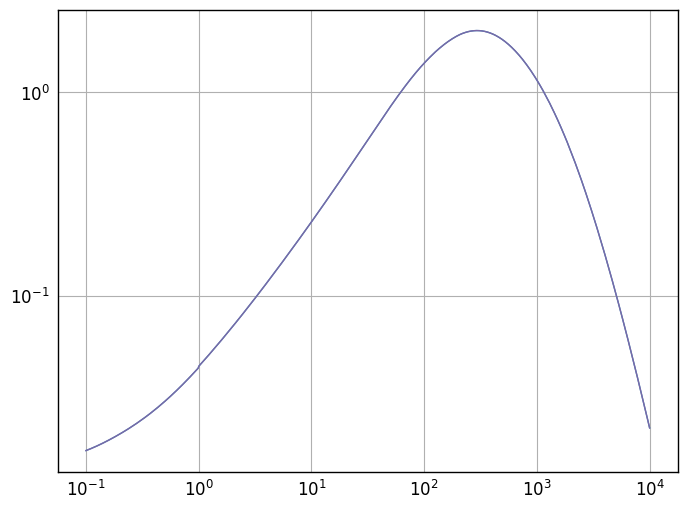

In [10]:
plt.plot(Epart,fluxes)
plt.plot(fluxdat[:,0],fluxdat[:,1])
plt.xscale('log')
plt.yscale('log')

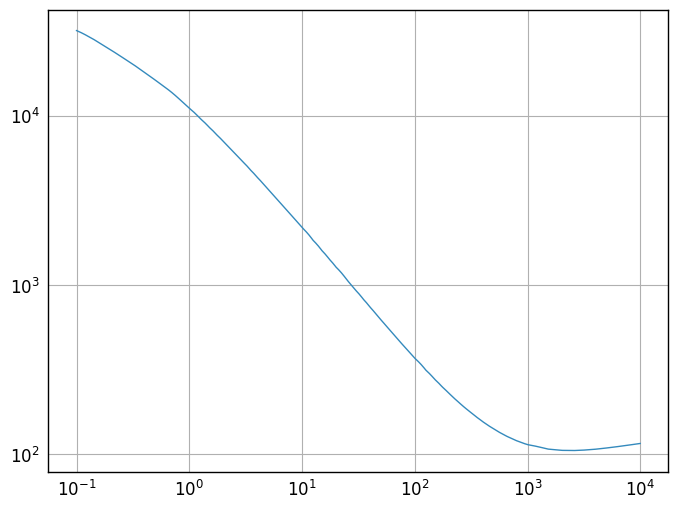

In [11]:
plt.plot(Epart,dEdx)
plt.xscale('log')
plt.yscale('log')

In [12]:
angs = np.linspace(0,np.pi/2,1000,endpoint=False)
thick_BAM = 38 # um, so BAM
thick_SM = 12 # um, so BAM

pathlens_BAM = thick_BAM/np.cos(angs)
pathlens_SM = thick_SM/np.cos(angs)

In [13]:
nbins = 200
pmin = 0
pmax = 40000

BAMheights = np.zeros(nbins)
SMheights = np.zeros(nbins)

for ii in range(len(Epart)):
    thisheightb, bin_lo = np.histogram(pathlens_BAM*dEdx[ii],bins=nbins,range=(pmin,pmax))
    BAMheights += thisheightb*fluxes[ii]
    
    thisheights, bin_lo = np.histogram(pathlens_SM*dEdx[ii],bins=nbins,range=(pmin,pmax))
    SMheights += thisheights*fluxes[ii]

In [14]:
bin_lo.shape

(201,)

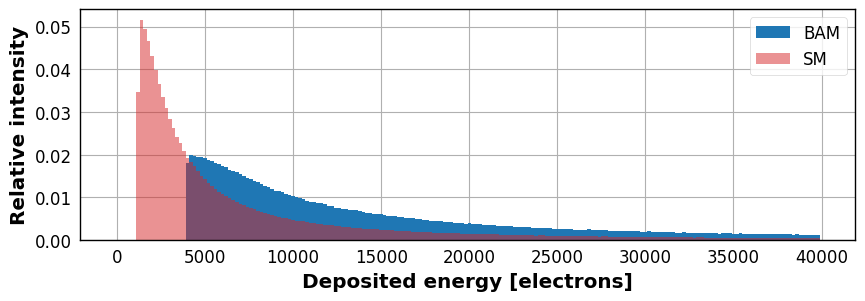

In [22]:
plt.bar(bin_lo[:-1],BAMheights/np.sum(BAMheights),width=bin_lo[1]-bin_lo[0],label='BAM',color='tab:blue')
plt.bar(bin_lo[:-1],SMheights/np.sum(SMheights),width=bin_lo[1]-bin_lo[0],alpha=0.5,label='SM',color='tab:red')

plt.xlabel("Deposited energy [electrons]")
plt.ylabel("Relative intensity")

plt.legend(loc='best')

plt.gcf().set_size_inches(10,3)

#plt.savefig("../../presentation_imgs/Ehist_expected.pdf",bbox_inches='tight')